C:\Users\Myvan\AppData\Local\Temp\ipykernel_28948\2029889227.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  relationship_df = df.applymap(map_relationship)



                         1     2     3     4     5     6     7     8     9    10    11    12    13  TCR
From / to department                                                                                   
1                     None     U     U     U     A     I     U     U     U     U     U     U     U   18
2                        U  None     U     U     A     I     U     U     U     U     U     U     U   18
3                        U     U  None     U     A     I     U     U     U     U     U     U     U   18
4                        U     U     U  None     A     I     U     U     U     U     U     U     U   18
5                        A     A     A     A  None     U     A     U     U     U     U     U     U   32
6                        I     I     I     I     U  None     I     U     U     U     U     U     U   22
7                        U     U     U     U     A     I  None     O     I     O     I     I     E   29
8                        U     U     U     U     U     U     O 

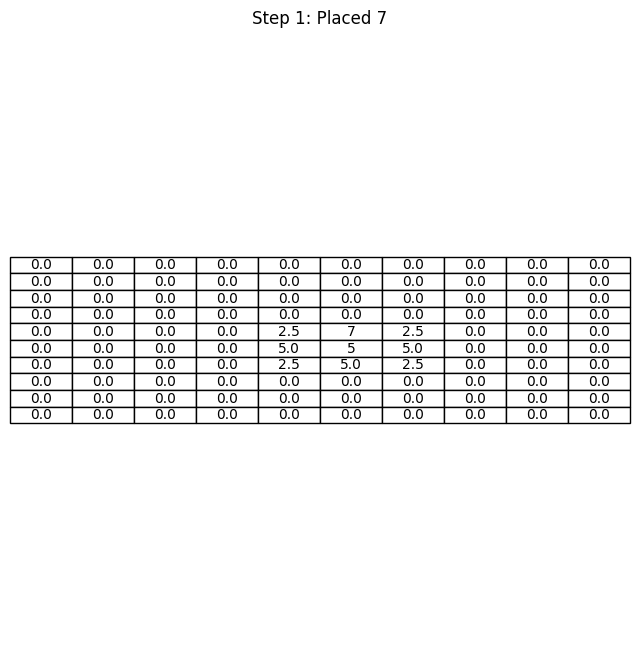

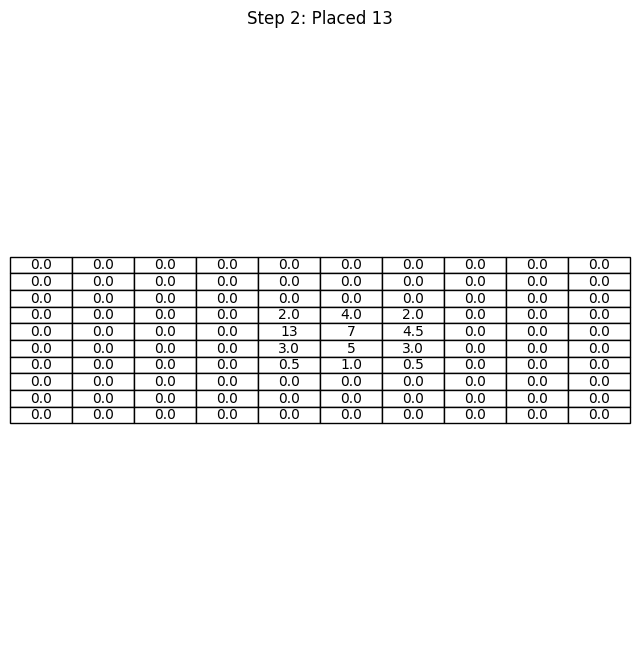

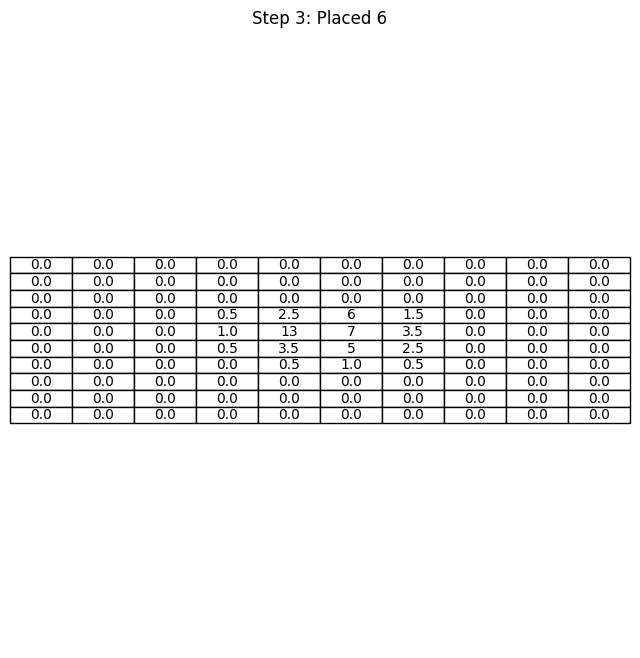

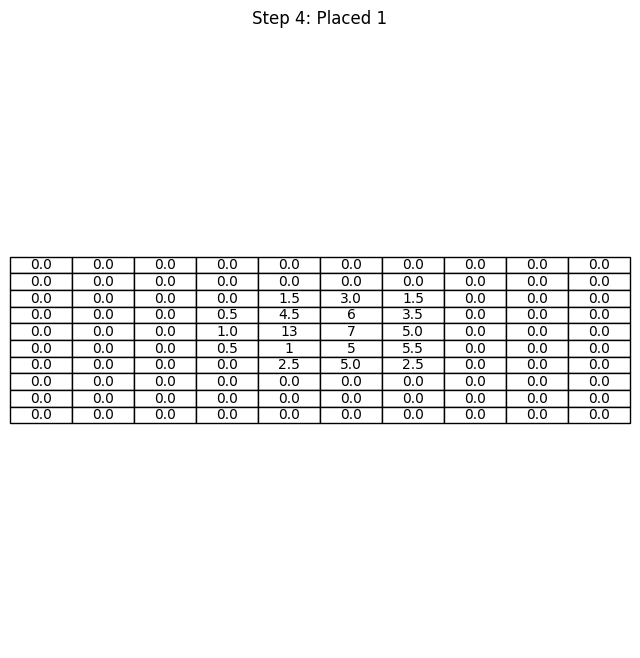

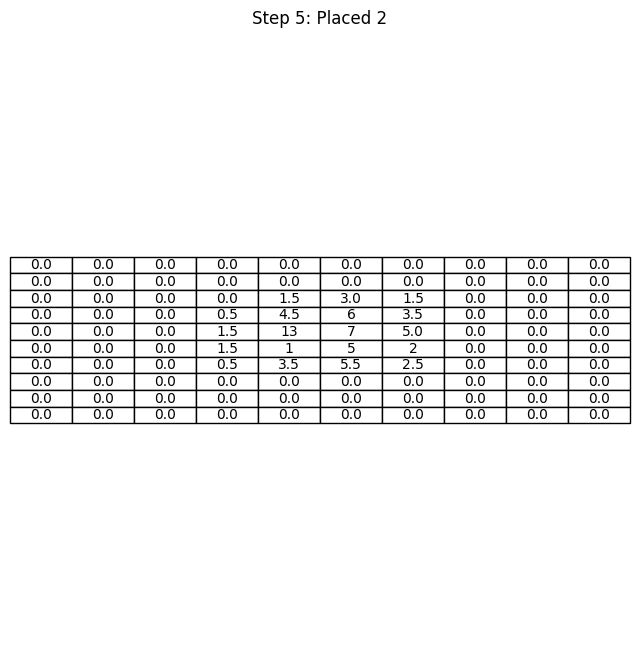

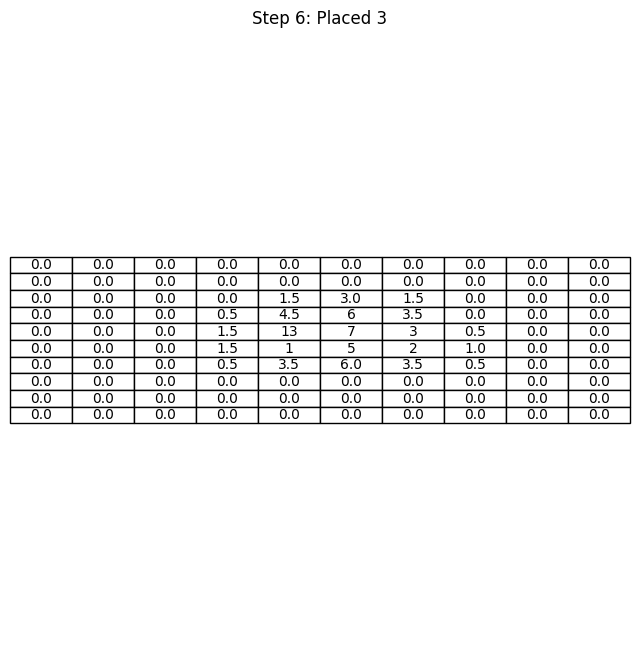

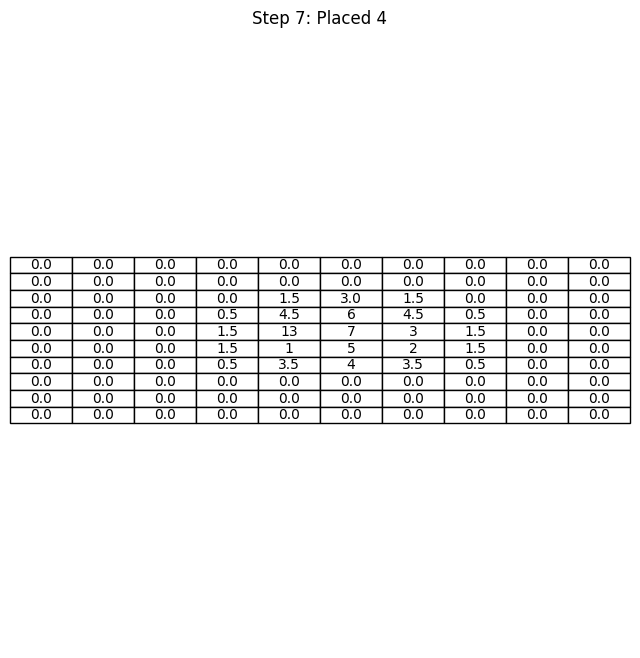

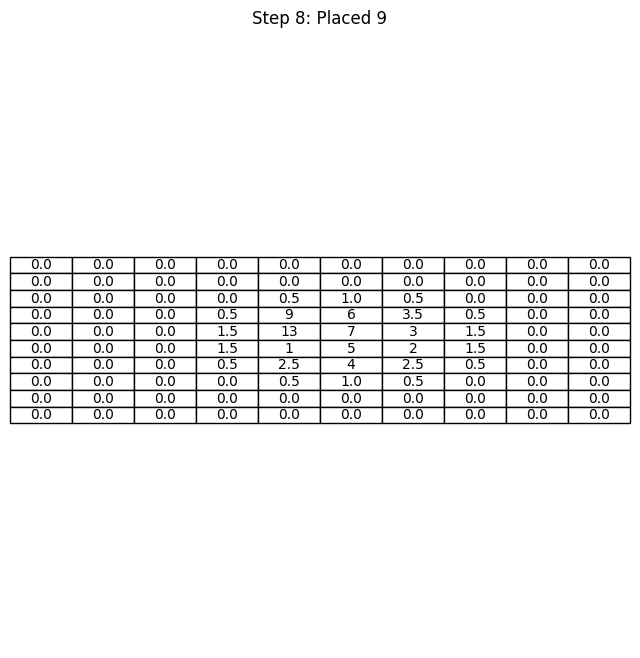

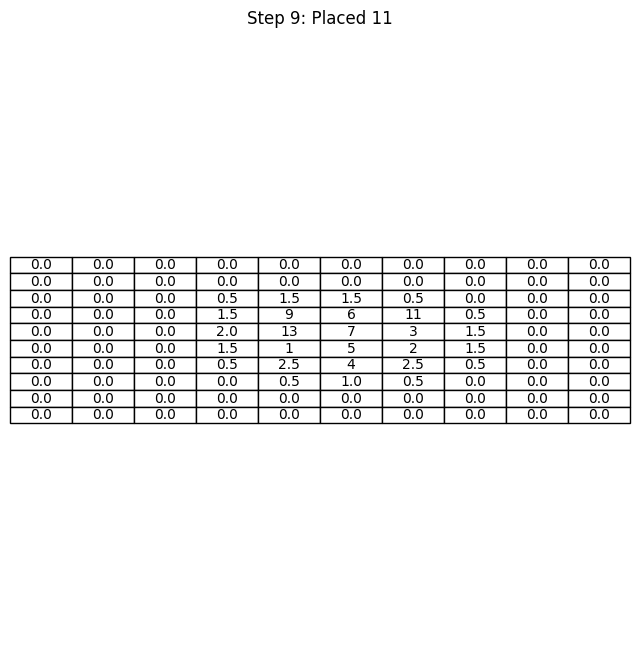

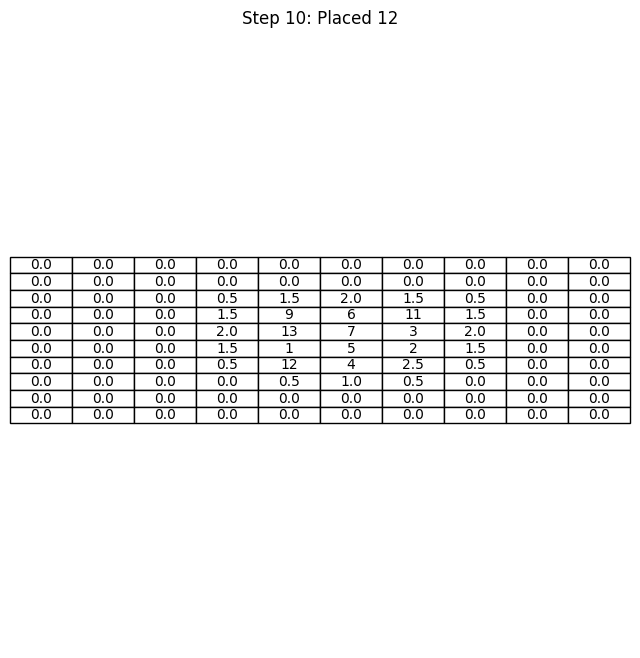

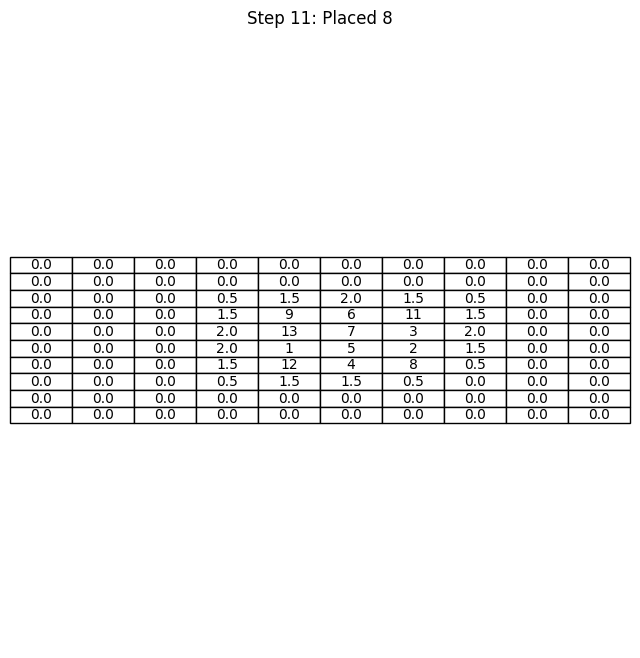

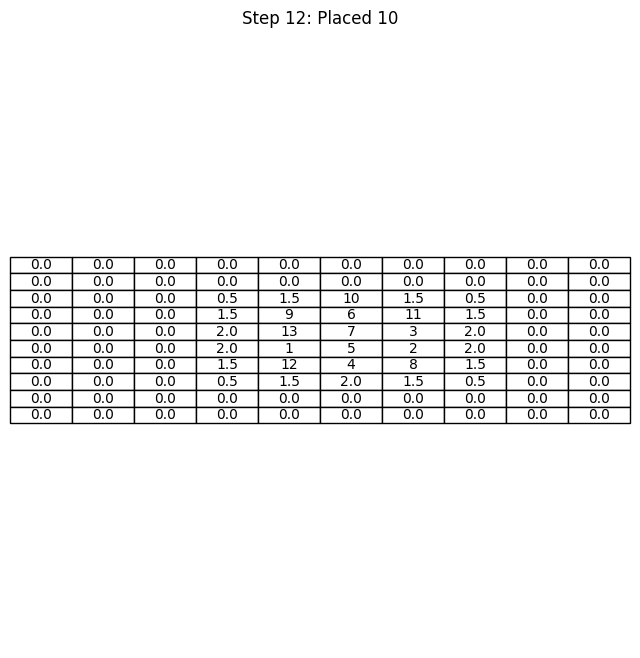

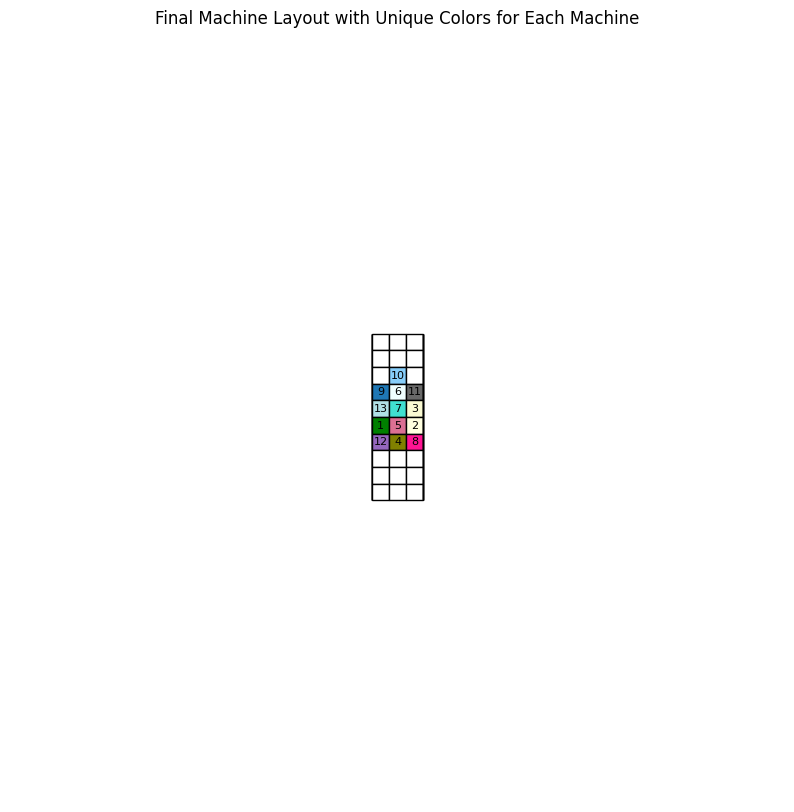

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random

# ============================
# 1. Đọc và xử lý dữ liệu Excel
# ============================
file_path = (r'C:\Users\Myvan\Downloads\daataa.xlsx')
df = pd.read_excel(file_path, header=0)
df.rename(columns={df.columns[0]: 'From / to department'}, inplace=True)
df['From / to department'] = df['From / to department'].astype(str)
df.columns = [str(col) for col in df.columns]
df = df.set_index('From / to department')
df = df.astype(float)
np.fill_diagonal(df.values, np.nan)

# ============================
# 2. Mapping AEIOU
# ============================
def map_relationship(value):
    if pd.isna(value):
        return None
    elif value > 700:
        return 'A'
    elif 400 < value <= 700:
        return 'E'
    elif 200 < value <= 400:
        return 'I'
    elif 1 < value <= 200:
        return 'O'
    elif value == 0:
        return 'U'

# Chuyển các giá trị trong bảng thành các mức quan hệ AEIOU
relationship_df = df.applymap(map_relationship)
print()

# Đảm bảo rằng tên các máy là dạng chuỗi không có phần thập phân dư thừa (vd. '1.0' -> '1')
def clean_machine_name(x):
    return str(int(float(x))) if str(x).replace('.', '', 1).isdigit() else str(x)

relationship_df.index = relationship_df.index.map(clean_machine_name)
relationship_df.columns = relationship_df.columns.map(clean_machine_name)
pd.set_option('display.max_columns', None)  # Hiển thị tất cả cột
pd.set_option('display.width', 1000)        # Độ rộng tối đa của dòng
pd.set_option('display.max_colwidth', None) # Không cắt cột
# print(relationship_df)

# ============================
# 3. Tính TCR
# ============================
relationship_weights = {'A': 5, 'E': 4, 'I': 3, 'O': 2, 'U': 1}

def calculate_tcr(row):
    return sum(relationship_weights.get(val, 0) for val in row if pd.notna(val))

# Tính tổng trọng số quan hệ (TCR) cho từng máy
tcr_series = relationship_df.apply(calculate_tcr, axis=1)
relationship_df['TCR'] = tcr_series
# print("TCR:\n", tcr_series)
print(relationship_df)

# ============================
# 4. Sắp xếp máy theo TCR và quan hệ ưu tiên
# ============================
relation_with_tcr = relationship_df.copy()
relation_with_tcr_copy = relation_with_tcr.copy()
sorted_machines = []

# Lấy máy có TCR cao nhất đầu tiên
current_machine = relation_with_tcr_copy['TCR'].idxmax()
sorted_machines.append(current_machine)
relation_with_tcr_copy.drop(index=current_machine, inplace=True)

while not relation_with_tcr_copy.empty:
    candidates = []
    for relation in ['A', 'E', 'I', 'O']:
        related_machines = []
        for candidate in relation_with_tcr_copy.index:
            try:
                if relationship_df.at[current_machine, candidate] == relation:
                    related_machines.append(candidate)
            except KeyError:
                continue
        if related_machines:
            candidates = related_machines
            break

    if candidates:
        next_machine = relation_with_tcr_copy.loc[candidates, 'TCR'].idxmax()
    else:
        next_machine = relation_with_tcr_copy['TCR'].idxmax()

    sorted_machines.append(next_machine)
    current_machine = next_machine
    relation_with_tcr_copy.drop(index=current_machine, inplace=True)

# In thứ tự máy theo CORELAP
print("\nThứ tự máy theo CORELAP:")
print(" -> ".join(sorted_machines))

# ============================
# 5. CORELAP Layout
# ============================
grid_size = 10
layout = np.full((grid_size, grid_size), '', dtype=object)
values_grid = np.zeros((grid_size, grid_size))
center_x, center_y = grid_size // 2, grid_size // 2
layout[center_x, center_y] = sorted_machines[0]
placed_machines = {(center_x, center_y): sorted_machines[0]}

def get_neighbor_positions(x, y):
    return [
        (x, y - 1), (x, y + 1), (x - 1, y), (x + 1, y),
        (x - 1, y - 1), (x - 1, y + 1), (x + 1, y - 1), (x + 1, y + 1)
    ]

def update_grid_values(current_machine):
    global values_grid
    values_grid = np.zeros((grid_size, grid_size))
    for (px, py), placed_machine in placed_machines.items():
        try:
            relation = relationship_df.loc[placed_machine, current_machine]
            relation_value = relationship_weights.get(relation, 0)
        except KeyError:
            continue
        for idx, (nx, ny) in enumerate(get_neighbor_positions(px, py)):
            if 0 <= nx < grid_size and 0 <= ny < grid_size and layout[nx, ny] == '':
                values_grid[nx, ny] += relation_value if idx < 4 else relation_value / 2

def plot_layout_step(step, machine):
    fig, ax = plt.subplots(figsize=(8, 8))
    merged_layout = np.full((grid_size, grid_size), '', dtype=object)
    for x in range(grid_size):
        for y in range(grid_size):
            merged_layout[x, y] = f"{layout[x, y]}" if layout[x, y] != '' else f"{values_grid[x, y]:.1f}"
    ax.table(cellText=merged_layout, loc='center', cellLoc='center')
    ax.axis('off')
    plt.title(f'Step {step}: Placed {machine}')
    plt.show()

for i in range(1, len(sorted_machines)):
    machine = sorted_machines[i]
    best_position = None
    highest_value = -1

    update_grid_values(machine)

    if np.all(values_grid == 0):
        distances = [(abs(x - center_x) + abs(y - center_y), (x, y))
                     for x in range(grid_size) for y in range(grid_size)
                     if layout[x, y] == '']
        best_position = min(distances, key=lambda k: k[0])[1]
    else:
        for x in range(grid_size):
            for y in range(grid_size):
                if layout[x, y] == '' and values_grid[x, y] > highest_value:
                    highest_value = values_grid[x, y]
                    best_position = (x, y)

    if best_position:
        bx, by = best_position
        layout[bx, by] = machine
        placed_machines[(bx, by)] = machine

    plot_layout_step(i, machine)

# ============================
# 6. Layout Cuối với Màu
# ============================
color_list = list(colors.TABLEAU_COLORS.values()) + list(colors.CSS4_COLORS.values())
random.shuffle(color_list)
machine_colors = color_list[:len(sorted_machines)]
machine_color_map = {machine: machine_colors[i] for i, machine in enumerate(sorted_machines)}

color_grid = np.full((grid_size, grid_size), '', dtype=object)
for x in range(grid_size):
    for y in range(grid_size):
        color_grid[x, y] = machine_color_map.get(layout[x, y], "white")

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=layout, cellLoc='center', loc='center', cellColours=color_grid)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(grid_size)))

plt.title("Final Machine Layout with Unique Colors for Each Machine")
plt.savefig('colored_machine_layout.png', dpi=300)
plt.show()
